In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Built-in
import os
from pathlib import Path

import matplotlib.pyplot as plt
# External
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.svm import SVC

# Local
from adad.adversarial.feature_squeezing import SklearnFeatureSqueezing
from adad.adversarial.magnet import AutoEncoder, Magnet
from adad.evaluate import permutation_auc, roc_ad


In [3]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/applicabilityDomain


In [4]:
file_smiles = os.path.join(PATH_ROOT, "data", "smiles", "Ames_smiles.csv")
df = pd.read_csv(file_smiles)
y = df['y'].to_numpy()

file_x = os.path.join(PATH_ROOT, "data", "maccs", "Ames_maccs.npy")
X = np.load(file_x)

file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())
col = idx_train.columns[0]
idx_test = idx_test[col].dropna(axis=0).to_numpy().astype(int)
idx_train = idx_train[col].dropna(axis=0).to_numpy().astype(int)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5204, 167) (1302, 167)
(5204,) (1302,)


In [5]:
n_encoders = 5
magnet = Magnet(AutoEncoder, n_encoders=n_encoders, batch_size=256)
magnet.fit(X_train)

100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


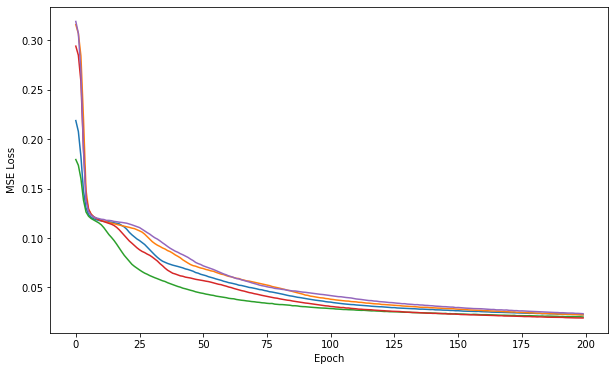

In [6]:
plt.figure(figsize=(10, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
for autoencoder in magnet.autoencoders:
    losses = autoencoder['losses']
    plt.plot(losses)
plt.show()

In [7]:
Xs_encode_tr = magnet.measure(X_train)
Xs_encode_te = magnet.measure(X_test)
for x in Xs_encode_te:
    print(x.shape)

(1302, 16)
(1302, 16)
(1302, 16)
(1302, 16)
(1302, 16)


In [8]:
clf = SVC(C=10)
clf.fit(X_train, y_train)
acc_train = clf.score(X_train, y_train)
print(f'Train score: {acc_train * 100:.2f}%')
acc_test = clf.score(X_test, y_test)
print(f'Test score: {acc_test * 100:.2f}%')

Train score: 93.97%
Test score: 81.57%


In [9]:
clf_params = [{'C': 10}] * n_encoders
fs = SklearnFeatureSqueezing(clf, SVC, n_encoders, clf_params)
fs.fit(Xs_encode_tr, y=y_train)

In [10]:
dm = fs.measure(X_test, Xs_encode_te)

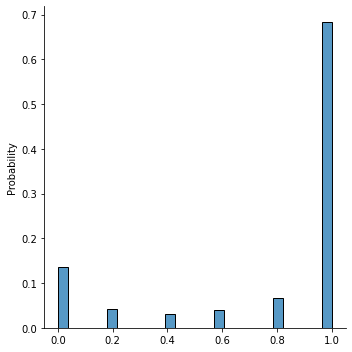

In [11]:
sns.displot(dm, stat='probability')
plt.show()

In [12]:
dm = 1. / (dm + 1e-6)

In [13]:
y_pred = clf.predict(X_test)
perm_auc, _ = permutation_auc(y_test, y_pred, dm)
print(perm_auc)

0.5202720099667774


In [14]:
fpr, tpr = roc_ad(y_test, y_pred, dm)
roc_auc = auc(fpr, tpr)

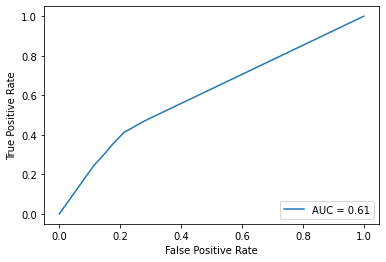

In [15]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

In [16]:
path_magnet = os.path.join(PATH_ROOT, 'demo', 'magnet_model')

magnet.save(path_magnet)
del magnet

In [17]:
magnet = Magnet(AutoEncoder, n_encoders=n_encoders)
magnet.load(path_magnet)

X_decode = magnet.decode(Xs_encode_te[0], magnet.autoencoders[0]['model'])
print(X_decode.shape)

(1302, 167)
